<a href="https://colab.research.google.com/github/imraunav/Computer-vision-EE511/blob/main/cv_segmentation_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!wget https://image-net.org/data/winter21_whole/n02110185.tar
!mkdir ./images
!tar -xf n02110185.tar -C ./images

--2023-11-26 17:09:05--  https://image-net.org/data/winter21_whole/n02110185.tar
Resolving image-net.org (image-net.org)... 171.64.68.16
Connecting to image-net.org (image-net.org)|171.64.68.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110878720 (106M) [application/x-tar]
Saving to: ‘n02110185.tar.1’

n02110185.tar.1     100%[===================>] 105.74M  13.0MB/s    in 9.2s    

2023-11-26 17:09:15 (11.4 MB/s) - ‘n02110185.tar.1’ saved [110878720/110878720]

mkdir: cannot create directory ‘./images’: File exists


In [4]:
path = "/content/images/n02110185_10089.JPEG"

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [6]:
img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.0

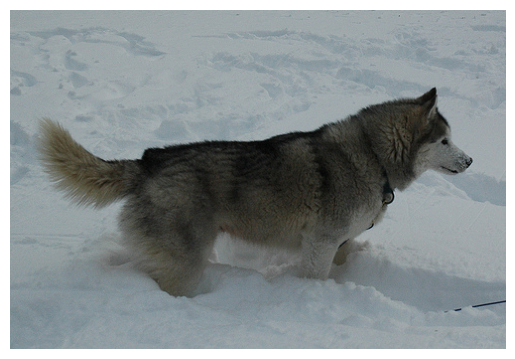

In [7]:
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
img.shape

(342, 500, 3)

In [16]:
class KMeans:
  def __init__(self, k=2):
    self.K = k
    # self.centroids = np.random.rand(k, feature_dim) # randomly init centroids

  def fit(self, X, max_iter = 50, tol=1e-3):
    # self.centroids = X[np.random.choice(X.shape[0], self.K, replace=False)] # randomly init centroids from data

    self.centroids = []
    for k in range(self.K):
      idx = np.random.randint(0, X.shape[0])
      self.centroids.append(X[idx])
    self.centroids = np.array(self.centroids)

    print("initial centroids")
    print(self.centroids)

    for _ in tqdm(range(max_iter)):
      # step 1. assign cluster
      labels = self.make_cluster(X)

      # step 2. compute new centroid
      new_centroids = []
      for k in range(self.K):
        new_centroids.append(np.mean(X[labels==k], axis=0))
      new_centroids = np.array(new_centroids)
      # print(new_centroids)

      # step 3. check convergence
      diff = np.linalg.norm(self.centroids - new_centroids, axis=0)
      if np.mean(diff) < tol:
        print("Converged!")
        break
      # update centriods
      self.centroids = new_centroids


  def make_cluster(self, X):
    labels = []
    for x in X:
      labels.append(self.assign_cluster(x))
    return np.array(labels)

  def assign_cluster(self, data_point):
    distances = []
    for k in range(self.K):
      distances.append(np.linalg.norm(data_point-self.centroids[k]))
    # distances = np.linalg.norm(data_point-self.centroids)
    return np.argmin(distances)

# Using rgb values as features

In [17]:
X = img.reshape((-1, 3))
X.shape

(171000, 3)

In [18]:
kmeans = KMeans(k=3)
kmeans.fit(X)

initial centroids
[[0.54901961 0.6        0.62352941]
 [0.22745098 0.18823529 0.14117647]
 [0.15686275 0.16078431 0.1372549 ]]


 28%|██▊       | 14/50 [00:57<02:28,  4.11s/it]

Converged!


In [27]:
segment_rgb = np.zeros_like(img)
# segment_rgb = np.zeros_like(img[:,:,0])
for i in range(segment_rgb.shape[0]):
  for j in range(segment_rgb.shape[1]):
    label = kmeans.assign_cluster(img[i, j])
    segment_rgb[i,j] = kmeans.centroids[label]
    # segment_rgb[i,j] = label


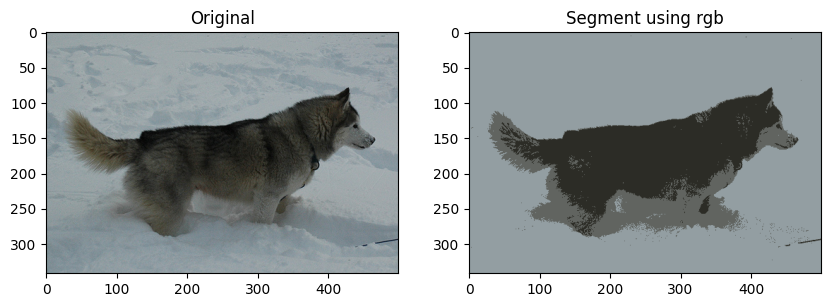

In [28]:
plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1,2,2)
plt.imshow(segment_rgb)
plt.title("Segment using rgb")

plt.show()

In [26]:
kmeans.centroids

array([[0.57765399, 0.62159728, 0.63805597],
       [0.38161021, 0.39426624, 0.3789862 ],
       [0.17463573, 0.17420071, 0.15062487]])

# Using RGB and x,y

In [29]:
h, w, _ = img.shape
h, w

(342, 500)

In [53]:
xy = np.zeros((h,w,2))

for i in range(h):
  for j in range(w):
    xy[i,j]= i/h, j/w

In [54]:
img.shape, xy.shape

((342, 500, 3), (342, 500, 2))

In [55]:
img_xy = np.concatenate([img, xy], axis=2)

In [56]:
img_xy.shape

(342, 500, 5)

In [57]:
X_xy = img_xy.reshape(-1, 5)

In [58]:
kmeans = KMeans(k=3)
kmeans.fit(X_xy)

initial centroids
[[0.63921569 0.67058824 0.68235294 0.18128655 0.762     ]
 [0.63921569 0.67058824 0.67843137 0.5497076  0.894     ]
 [0.19607843 0.19215686 0.17647059 0.4619883  0.412     ]]


 12%|█▏        | 6/50 [00:24<03:02,  4.14s/it]

Converged!


In [59]:
segment_rgbxy = np.zeros_like(img)
# segment_rgbxy = np.zeros_like(img[:,:,0])
for i in range(segment_rgbxy.shape[0]):
  for j in range(segment_rgbxy.shape[1]):
    label = kmeans.assign_cluster(img_xy[i, j])
    segment_rgbxy[i,j] = kmeans.centroids[label][:3]
    # segment_rgbxy[i,j] = label

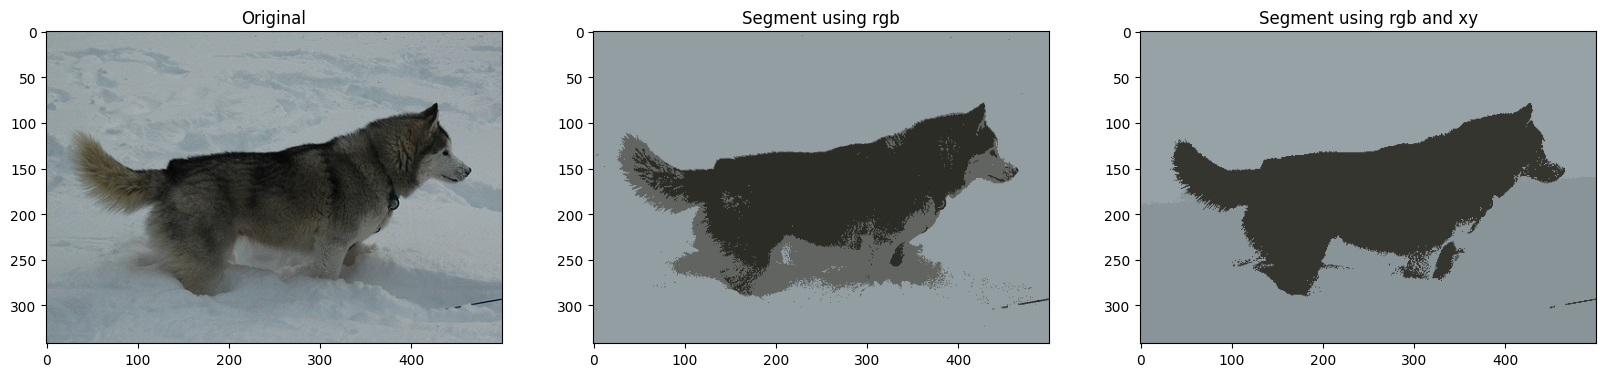

In [62]:
plt.figure(figsize=(20, 8))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(segment_rgb)
plt.title("Segment using rgb")

plt.subplot(1,3,3)
plt.imshow(segment_rgbxy)
plt.title("Segment using rgb and xy")

plt.show()

In [61]:
kmeans.centroids

array([[0.5946133 , 0.63708972, 0.65144759, 0.20085045, 0.4676506 ],
       [0.53813748, 0.58049598, 0.59668034, 0.79381584, 0.52654119],
       [0.21085502, 0.21133132, 0.18654318, 0.52672411, 0.50735526]])